In [1]:
import data_smoothing
import find_peaks
import peak_character
import peak_classify
import feature_visualizer

# Load real TA data

In [2]:
data_nm, data_time, data_z = data_smoothing.load_data_csv('exp03_20180103 -t0 -chirp.csv')

# Smoothen data

In [3]:
smooth_matx = data_smoothing.earth_smooth_matrix(data_nm, data_z)

/usr/local/lib/python3.5/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/usr/local/lib/python3.5/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


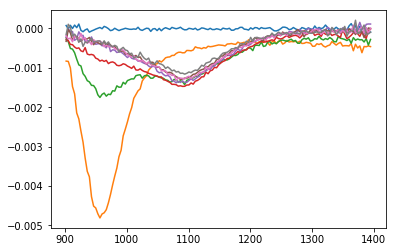

In [13]:
import matplotlib.pyplot as plt
plt.plot(data_nm, data_z[:,1::100])

# Find peaks

In [21]:
threshold = 0.25
mindist = 0
idx, height, fwhm = peak_character.peak_matrix(data_nm,smooth_matx, threshold, mindist)

In [22]:
idx.describe()

,0,1,2,3
count,749.00000,149.000000,7.000000,3.000000
mean,45.53004,54.087248,100.714286,126.000000
std,19.56207,17.428593,43.496032,13.453624
min,5.00000,11.000000,20.000000,111.000000
25%,21.00000,49.000000,87.000000,120.500000
50%,56.00000,52.000000,122.000000,130.000000
75%,56.00000,54.000000,128.000000,133.500000
max,135.00000,136.000000,133.000000,137.000000


In [23]:
height.describe()

,0,1,2,3
count,749.000000,149.000000,7.000000,3.000000
mean,-0.001437,-0.001106,0.000004,0.000008
std,0.000753,0.000456,0.000047,0.000067
min,-0.004840,-0.001438,-0.000039,-0.000065
25%,-0.001418,-0.001330,-0.000031,-0.000021
50%,-0.001311,-0.001280,-0.000022,0.000023
75%,-0.001203,-0.001203,0.000041,0.000045
max,0.000084,0.000106,0.000072,0.000066


In [24]:
fwhm.describe()

,0,1,2,3
count,749.000000,149.000000,7.000000,3.000000
mean,174.347972,152.547732,131.497857,56.666667
std,51.113118,47.759552,107.992865,59.022044
min,17.108000,27.454000,31.250000,20.870000
25%,161.780000,137.800000,57.300000,22.605000
50%,168.643000,144.700000,82.325000,24.340000
75%,189.251000,161.810000,202.615000,74.565000
max,458.882000,435.040000,287.080000,124.790000


# convert peak index to nm

In [5]:
import numpy as np
idx_np = np.nan_to_num(np.array(idx))

peak1 = np.empty(len(data_time))
peak2 = np.empty_like(peak1)
for i in range(np.shape(idx_np)[0]):
    peak1[i] = data_nm[int(idx_np[:, 0][i])]
    peak2[i] = data_nm[int(idx_np[:, 1][i])]

In [6]:
import remove_outlier as outlier
import matplotlib.pyplot as plt

In [7]:
peak1_corr = outlier.id_outliers_replacewith_interp(data_time, peak1, 1, 50)

15


In [8]:
peak1_isotonic = outlier.isotonic(data_time, peak1_corr)

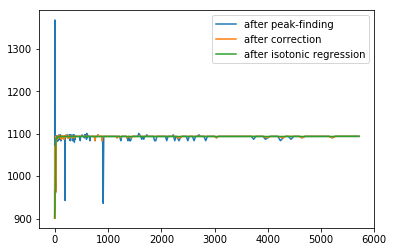

In [9]:
plt.figure()

plt.plot(data_time, peak1, label = 'after peak-finding')
plt.plot(data_time, peak1_corr, label = 'after correction')
plt.plot(data_time, peak1_isotonic, label = 'after isotonic regression')
plt.legend()

In [26]:
np.shape(peak1_corr)

(786,)

In [52]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def data_grouping(index_df, height_df, fwhm_df):
    peak_list = []
    
    for i in range(index_df.shape[0]):
        for j in range(index_df.shape[1]):
            peak_list.append(
            [index_df.loc[i,j], height_df.loc[i,j], fwhm_df.loc[i,j], i])
        
    all_points = pd.DataFrame(peak_list, 
    columns=['Position', 'Height', 'Width', 'Time'])
    corrected_output = all_points.fillna(value=0)
    
    return corrected_output

def cluster_classifier(index_df, corrected_output):
    found_peak = 3
    cluster = KMeans(n_clusters=found_peak).fit(corrected_output.iloc[:,:-1])
    print(cluster.labels_)
    peak_dict = {}
    
    for i in range(found_peak):
            peak_dict['peak_%s' % i] = []
            
    for j in range(corrected_output.shape[0]):
        peak = cluster.predict([corrected_output.values[j,:-1]])
        signal = corrected_output.loc[j][1]
        for k in range(found_peak):
            if (peak == k):
                peak_dict['peak_%s' % k].append(corrected_output.values[j])
                print('found a match')

    return peak_dict

In [27]:
corrected_output = data_grouping(idx, height, fwhm)
corrected_output

,Position,Height,Width,Time
0,0.0,0.000000,0.000,0
1,0.0,0.000000,0.000,0
2,0.0,0.000000,0.000,0
3,0.0,0.000000,0.000,0
4,11.0,-0.000061,448.619,1
5,0.0,0.000000,0.000,1
6,0.0,0.000000,0.000,1
7,0.0,0.000000,0.000,1
8,14.0,-0.000023,199.274,2
9,0.0,0.000000,0.000,2


In [30]:
df = corrected_output.drop(corrected_output[abs(corrected_output.Height) < 0.001].index)

In [51]:
df = df.reset_index(drop=True)
df.describe()

,Position,Height,Width,Time
count,824.000000,824.000000,824.000000,824.000000
mean,46.604369,-0.001502,171.134871,401.241505
std,15.374112,0.000627,40.356838,203.826156
min,15.000000,-0.004840,75.358000,88.000000
25%,49.000000,-0.001408,158.372500,218.750000
50%,55.000000,-0.001318,165.260000,373.500000
75%,56.000000,-0.001228,178.964000,579.250000
max,58.000000,-0.001019,278.493000,785.000000


In [53]:
peak_dict = cluster_classifier(idx, df)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 2 2 2 2 2 0
 2 0 2 0 2 2 0 2 0 2 0 2 2 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found 

In [54]:
peak_dict

{'peak_0': [array([ 4.50000000e+01, -1.13820208e-03,  1.34400000e+02,  1.30000000e+02]),
  array([ 4.50000000e+01, -1.14156598e-03,  1.41310000e+02,  1.35000000e+02]),
  array([ 4.60000000e+01, -1.15355508e-03,  1.34400000e+02,  1.39000000e+02]),
  array([ 4.40000000e+01, -1.13720488e-03,  1.30950000e+02,  1.40000000e+02]),
  array([ 4.60000000e+01, -1.18579058e-03,  1.34400000e+02,  1.41000000e+02]),
  array([ 5.0000000e+01, -1.1583573e-03,  1.2411000e+02,  1.4200000e+02]),
  array([ 4.20000000e+01, -1.28168536e-03,  1.41220000e+02,  1.43000000e+02]),
  array([ 4.40000000e+01, -1.16366798e-03,  1.37800000e+02,  1.44000000e+02]),
  array([ 4.60000000e+01, -1.14531756e-03,  1.51620000e+02,  1.45000000e+02]),
  array([ 4.50000000e+01, -1.27640892e-03,  1.41260000e+02,  1.51000000e+02]),
  array([ 4.60000000e+01, -1.26435175e-03,  1.34370000e+02,  1.52000000e+02]),
  array([ 4.80000000e+01, -1.23049522e-03,  1.34390000e+02,  1.53000000e+02]),
  array([ 4.40000000e+01, -1.23576536e-03,  1.

In [10]:
corrected_output = peak_classify.data_grouping(idx, height, fwhm)

In [11]:
peak_dict = peak_classify.cluster_classifier(idx, corrected_output)

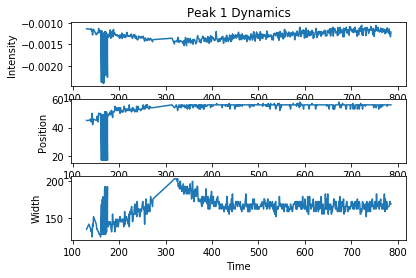

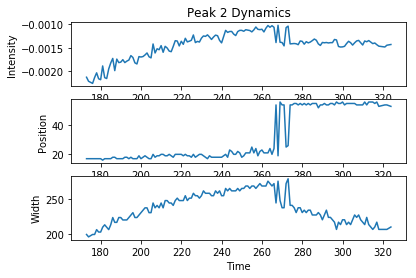

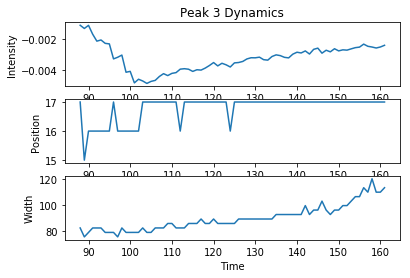

In [55]:
output = feature_visualizer.visualize(peak_dict)

# peak #2

In [14]:
peak2_corr = outlier.id_outliers_replacewith_interp(data_time, peak2, 1, 100)

7


In [15]:
peak2_isotonic = outlier.isotonic(data_time, peak2_corr)

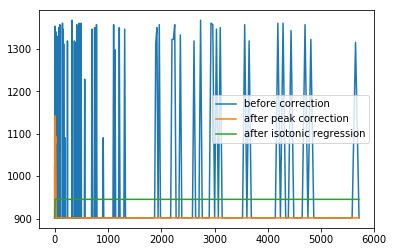

In [16]:
plt.figure()
plt.plot(data_time, peak2, label = 'before correction')
plt.plot(data_time, peak2_corr, label = 'after peak correction')
plt.plot(data_time, peak2_isotonic, label = 'after isotonic regression')
plt.legend()

In [16]:
height.describe()

,0,1,2,3,4
count,760.000000,224.000000,26.000000,8.000000,1.000000
mean,-0.001416,-0.000759,-0.000068,0.000013,0.000016
std,0.000766,0.000620,0.000129,0.000055,NaN
min,-0.004840,-0.001438,-0.000357,-0.000065,0.000016
25%,-0.001415,-0.001310,-0.000044,-0.000021,0.000016
50%,-0.001309,-0.001200,-0.000019,0.000007,0.000016
75%,-0.001199,-0.000029,0.000006,0.000042,0.000016
max,0.000084,0.000092,0.000072,0.000106,0.000016


In [ ]:
peak_dict